# Hosting ControlNet/Lora models on SageMaker using BYOC (Bring-your-own-container).

In this notebook, we explore how to host ControlNet/Lora models on SageMaker asynchronous endpoint using BYOC (Bring-your-own-container).

In this notebook, under the hood we use stable-diffusion-webui to generate image with Lora and ControlNet support. 

## Build Docker image and push to ECR.

Initialize the variables for SageMaker default bucket, role, and AWS account ID, and current AWS region.

In [1]:
import sagemaker

sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
role = sagemaker.get_execution_role()

import boto3

account_id = boto3.client("sts").get_caller_identity().get("Account")
region_name = boto3.session.Session().region_name

Execute the script - build_and_push.sh to build Docker images for SageMaker endpoint.

In [148]:
!chmod +x build_and_push.sh && ./build_and_push.sh $region_name

set -e

# This script shows how to build the Docker image and push it to ECR to be ready for use
# by SageMaker.

# The argument to this script is the region name. 

if [ "$#" -ne 1 ] ; then
    echo "usage: $0 [region-name] [option]"
    exit 1
fi

region=$1

# Get the account number associated with the current IAM credentials
account=$(aws sts get-caller-identity --query Account --output text)

if [ $? -ne 0 ]
then
    exit 255
fi

inference_image=all-in-one-ai-stable-diffusion-webui-inference-api
inference_fullname=${account}.dkr.ecr.${region}.amazonaws.com/${inference_image}:latest

# If the repository doesn't exist in ECR, create it.
aws ecr describe-repositories --repository-names "${inference_image}" --region ${region} || aws ecr create-repository --repository-name "${inference_image}" --region ${region}
{
    "repositories": [
        {
            "repositoryArn": "arn:aws:ecr:us-west-1:034068151705:repository/all-in-one-ai-stable-diffusion-webui-inference-api",
            "r

## Deploy to SageMaker Asychronous Endpoint

Upload the dummy file to S3 to meet the requirement of SageMaker Endpoint for model data.

In [3]:
model_data = "s3://{0}/stable-diffusion-webui/data/model.tar.gz".format(bucket)
!touch dummy
!tar czvf model.tar.gz dummy
!rm dummy
!aws s3 cp model.tar.gz $model_data

dummy
upload: ./model.tar.gz to s3://sagemaker-us-west-1-034068151705/stable-diffusion-webui/data/model.tar.gz


Initialized the variables for URI of Docker Inference Endpoint.

In [4]:
model_name = None
image_uri = "{0}.dkr.ecr.{1}.amazonaws.com/all-in-one-ai-stable-diffusion-webui-inference-api:latest".format(
    account_id, region_name
)

Define the models configuration in order to download those models from one of source - HTTP, S3 and HuggingFace.

In [5]:
import json

huggingface_models = [
    {
        "repo_id": "runwayml/stable-diffusion-v1-5",
        "filename": "v1-5-pruned.ckpt",
        "name": "Stable-diffusion",
    },
    {
        "repo_id": "lllyasviel/ControlNet",
        "filename": "models/control_sd15_canny.pth",
        "name": "ControlNet",
    },
]

http_models = [
    {
        "uri": "https://civitai.com/api/download/models/7627",
        "filename": "2bNierAutomataLora_v2b.safetensors",
        "name": "Lora",
    }
]

model_environment = {
    "ckpt": "/tmp/models/Stable-diffusion/v1-5-pruned.ckpt",
    "huggingface_models": json.dumps(huggingface_models),
    "http_models": json.dumps(http_models),
    "generated_images_s3uri": f"s3://{bucket}/stable-diffusion-webui/generated/",
    "embeddings_s3uri": f"s3://{bucket}/stable-diffusion-webui/embeddings/",
    "hypernetwork_s3uri": f"s3://{bucket}/stable-diffusion-webui/hypernetwork/",
}

Define the model, instance type and instance initial count for SageMaker endpoint.

In [11]:
from sagemaker.model import Model
from sagemaker.predictor import Predictor

model = Model(
    name=model_name,
    model_data=model_data,
    role=role,
    image_uri=image_uri,
    env=model_environment,
    predictor_cls=Predictor,
)

instance_type = "ml.g4dn.4xlarge"
instance_count = 1

Define the SageMaker Asychronous Inference config

In [12]:
from sagemaker.async_inference import AsyncInferenceConfig

async_config = AsyncInferenceConfig(
    output_path="s3://{0}/{1}/asyncinvoke/out/".format(bucket, "stable-diffusion-webui")
)

Here we use asynchronous inference since asynchronous inference is more suitable for workloads with large payload sizes and long inference processing times. 

In [149]:
predictor = model.deploy(
    instance_type=instance_type,
    initial_instance_count=instance_count,
    volume_size_in_gb=225,
    container_startup_health_check_timeout=1800,
    async_inference_config=async_config,
)

------------------!

## Generate images using Lora models

LoRA (Low-Rank Adaptation of Large Language Models) models have become the standard to extend the Stable Diffusion models. Let's use Lora model to generate images.

In [150]:
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

predictor.serializer = JSONSerializer()
predictor.deserializer = JSONDeserializer()

inputs = {
    "task": "text-to-image",
    "sd_model_checkpoint": "v1-5-pruned.ckpt",
    "txt2img_payload": {
        "enable_hr": False,
        "denoising_strength": 0,
        "hr_scale": 2,
        "hr_upscaler": "",
        "hr_second_pass_steps": 0,
        "hr_resize_x": 0,
        "hr_resize_y": 0,
        "prompt": "yorha no. 2 type b, 1girl, bangs, black blindfold, black dress, black gloves, black hairband, blindfold, blindfold removed, breasts, cleavage cutout, clothing cutout, commentary request, dress, gloves, hairband, half-closed eyes, hand up, highres, io (sinking=carousel), juliet sleeves, long sleeves, looking at viewer, medium breasts, mole, mole under mouth, nier (series), nier automata, no blindfold, parted lips, puffy sleeves, short hair, solo, thighhighs, turtleneck, upper body, white hair, bokeh <lora:2bNierAutomataLora_v2b:0.5>",
        "styles": [""],
        "seed": 2674865251,
        "subseed": -1,
        "subseed_strength": 0,
        "seed_resize_from_h": -1,
        "seed_resize_from_w": -1,
        "sampler_name": "",
        "batch_size": 1,
        "n_iter": 1,
        "steps": 20,
        "cfg_scale": 7,
        "width": 512,
        "height": 512,
        "restore_faces": False,
        "tiling": False,
        "do_not_save_samples": False,
        "do_not_save_grid": False,
        "negative_prompt": "(worst quality, low quality:1.3)",
        "eta": 0,
        "s_churn": 0,
        "s_tmax": 0,
        "s_tmin": 0,
        "s_noise": 1,
        "override_settings": {},
        "override_settings_restore_afterwards": True,
        "script_args": [],
        "sampler_index": "DPM++ SDE Karras",
        "script_name": "",
        "send_images": True,
        "save_images": False,
        "alwayson_scripts": {},
    },
}

prediction = predictor.predict_async(inputs)

Helper function for S3.

In [151]:
import json
import io

s3_resource = boto3.resource("s3")


def get_bucket_and_key(s3uri):
    pos = s3uri.find("/", 5)
    bucket = s3uri[5:pos]
    key = s3uri[pos + 1 :]
    return bucket, key

Wait until the asychronous inference is done in case we use asynchronous inference for image generation. 

In [152]:
from sagemaker.async_inference.waiter_config import WaiterConfig

print(f"Response object: {prediction}")
print(f"Response output path: {prediction.output_path}")
print("Start Polling to get response:")

import time

start = time.time()

config = WaiterConfig(
    max_attempts=100, delay=10  #  number of attempts  #  time in seconds to wait between attempts
)

prediction.get_result(config)

print(f"Time taken: {time.time() - start}s")

Response object: <sagemaker.async_inference.async_inference_response.AsyncInferenceResponse object at 0x7f09c51700a0>
Response output path: s3://sagemaker-us-west-1-034068151705/stable-diffusion-webui/asyncinvoke/out/1624e48b-c230-470e-a4fb-72cfd4ae3bec.out
Start Polling to get response:
Time taken: 21.05852484703064s


Process the generated images from asynchronous inference result.

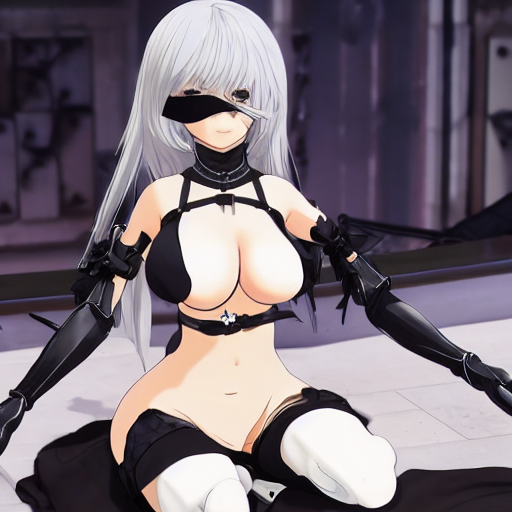

In [153]:
import traceback
from PIL import Image
import uuid
from datetime import datetime

try:
    output_bucket, output_key = get_bucket_and_key(prediction.output_path)
    output_obj = s3_resource.Object(output_bucket, output_key)
    body = output_obj.get()["Body"].read().decode("utf-8")
    for image_uri in json.loads(body)["parameters"]["image_url"].split(','):
        image_bucket, image_key = get_bucket_and_key(image_uri)
        image_object = s3_resource.Object(image_bucket, image_key)
        image = Image.open(io.BytesIO(image_object.get()["Body"].read()))
        image.show()
        image.save(datetime.now().strftime(f"%Y%m%d%H%M%S-{uuid.uuid4()}.jpg"))
    if json.loads(body)["parameters"]["image_mask_url"] != '':
        for image_uri in json.loads(body)["parameters"]["image_mask_url"].split(','):
            image_bucket, image_key = get_bucket_and_key(image_uri)
            image_object = s3_resource.Object(image_bucket, image_key)
            image = Image.open(io.BytesIO(image_object.get()["Body"].read()))
            image.show()
            image.save(datetime.now().strftime(f"%Y%m%d%H%M%S-{uuid.uuid4()}.jpg"))
except Exception as e:
    traceback.print_exc()
    print(e)

In [159]:
body

'{"images":[""],"parameters":{"id_task":null,"status":1,"image_url":"s3://sagemaker-us-west-1-034068151705/stable-diffusion-webui/generated/2023-06-07/20230607093831-750e0088-19fd-4954-b6fd-30d916600dce.png","seed":"2238052222","error_msg":"","image_mask_url":"s3://sagemaker-us-west-1-034068151705/stable-diffusion-webui/generated/2023-06-07/20230607093831-254f521d-200f-4084-92c3-546133835151.png"},"info":""}'

## Generate images using ControlNet models

ControlNet is a neural network structure to control diffusion models by adding extra conditions.

In [154]:
from PIL import Image
import base64
import io


def encode_image_to_base64(image):
    with io.BytesIO() as output_bytes:
        image.save(output_bytes, format="JPEG")
        bytes_data = output_bytes.getvalue()

    encoded_string = base64.b64encode(bytes_data)

    base64_str = str(encoded_string, "utf-8")
    mimetype = "image/jpeg"
    image_encoded_in_base64 = (
        "data:" + (mimetype if mimetype is not None else "") + ";base64," + base64_str
    )
    return image_encoded_in_base64


def decode_base64_to_image(encoding):
    if encoding.startswith("data:image/"):
        encoding = encoding.split(";")[1].split(",")[1]
    try:
        image = Image.open(io.BytesIO(base64.b64decode(encoding)))
        return image
    except Exception as e:
        print(e)

Open an image for as ControlNet image

In [155]:
from PIL import Image

image = Image.open("./images/inference/ControlNet/bal-source.png").convert("RGB")

Define the payload for SageMaker inference.

In [156]:
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

predictor.serializer = JSONSerializer()
predictor.deserializer = JSONDeserializer()

inputs = {
    "task": "text-to-image",
    "model": "v1-5-pruned.ckpt",
    "txt2img_payload": {
        "enable_hr": False,
        "denoising_strength": 0,
        "hr_scale": 2,
        "hr_upscaler": "",
        "hr_second_pass_steps": 0,
        "hr_resize_x": 0,
        "hr_resize_y": 0,
        "prompt": "man on the hill",
        "styles": [""],
        "seed": -1,
        "subseed": -1,
        "subseed_strength": 0,
        "seed_resize_from_h": -1,
        "seed_resize_from_w": -1,
        "sampler_name": "",
        "batch_size": 1,
        "n_iter": 1,
        "steps": 20,
        "cfg_scale": 7,
        "width": 512,
        "height": 512,
        "restore_faces": False,
        "tiling": False,
        "do_not_save_samples": False,
        "do_not_save_grid": False,
        "negative_prompt": "",
        "eta": 0,
        "s_churn": 0,
        "s_tmax": 0,
        "s_tmin": 0,
        "s_noise": 1,
        "override_settings": {},
        "override_settings_restore_afterwards": True,
        "script_args": [],
        "sampler_index": "DPM++ SDE Karras",
        "script_name": "",
        "send_images": True,
        "save_images": False,
        "alwayson_scripts": {
            "controlnet": {
                "args": [
                    {
                        "enabled": True,
                        "module": "none",
                        "model": "control_sd15_canny [fef5e48e]",
                        "weight": 1,
                        "image": "https://painting-1251215091.cos.ap-shanghai.myqcloud.com/api/2023_05_23/20230523105334783830_e7d55f25dec7f9e7a3174b936c1dd011.png",
                        "low_vram": False,
                        "processor_res": 64,
                        "threshold_a": 64,
                        "threshold_b": 64,
                        "guidance_start": 0,
                        "guidance_end": 1,
                        "guess_mode": False,
                    }
                ]
            }
        }
    }
}

prediction = predictor.predict_async(inputs)

Wait until the asynchronous inference is done in case we use asynchronous inference for image generation. 

In [157]:
from sagemaker.async_inference.waiter_config import WaiterConfig

print(f"Response object: {prediction}")
print(f"Response output path: {prediction.output_path}")
print("Start Polling to get response:")

import time

start = time.time()

config = WaiterConfig(
    max_attempts=100, delay=10  #  number of attempts  #  time in seconds to wait between attempts
)

prediction.get_result(config)

print(f"Time taken: {time.time() - start}s")

Response object: <sagemaker.async_inference.async_inference_response.AsyncInferenceResponse object at 0x7f09c4602460>
Response output path: s3://sagemaker-us-west-1-034068151705/stable-diffusion-webui/asyncinvoke/out/7164f556-723d-48bb-8609-10dc26c63aa5.out
Start Polling to get response:
Time taken: 31.06787943840027s


Process the generated images from asynchronous inference result.

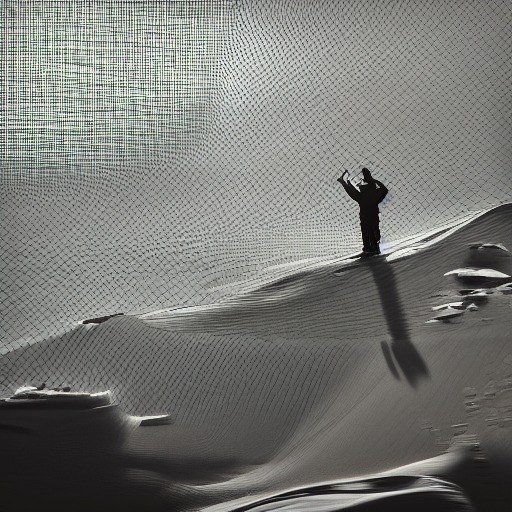

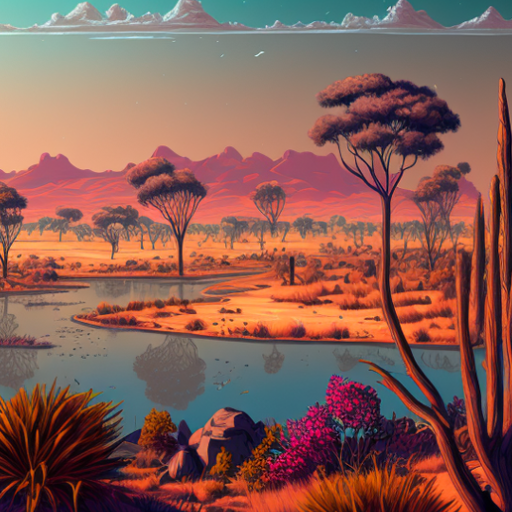

In [158]:
import traceback
from PIL import Image
import uuid
from datetime import datetime

try:
    output_bucket, output_key = get_bucket_and_key(prediction.output_path)
    output_obj = s3_resource.Object(output_bucket, output_key)
    body = output_obj.get()["Body"].read().decode("utf-8")
    for image_uri in json.loads(body)["parameters"]["image_url"].split(','):
        image_bucket, image_key = get_bucket_and_key(image_uri)
        image_object = s3_resource.Object(image_bucket, image_key)
        image = Image.open(io.BytesIO(image_object.get()["Body"].read()))
        image.show()
        image.save(datetime.now().strftime(f"%Y%m%d%H%M%S-{uuid.uuid4()}.jpg"))
    if json.loads(body)["parameters"]["image_mask_url"] != '':
        for image_uri in json.loads(body)["parameters"]["image_mask_url"].split(','):
            image_bucket, image_key = get_bucket_and_key(image_uri)
            image_object = s3_resource.Object(image_bucket, image_key)
            image = Image.open(io.BytesIO(image_object.get()["Body"].read()))
            image.show()
            image.save(datetime.now().strftime(f"%Y%m%d%H%M%S-{uuid.uuid4()}.jpg"))
except Exception as e:
    traceback.print_exc()
    print(e)

In [160]:
body

'{"images":[""],"parameters":{"id_task":null,"status":1,"image_url":"s3://sagemaker-us-west-1-034068151705/stable-diffusion-webui/generated/2023-06-07/20230607093831-750e0088-19fd-4954-b6fd-30d916600dce.png","seed":"2238052222","error_msg":"","image_mask_url":"s3://sagemaker-us-west-1-034068151705/stable-diffusion-webui/generated/2023-06-07/20230607093831-254f521d-200f-4084-92c3-546133835151.png"},"info":""}'

## [Optional] Create auto-scaling group for SageMaker endpoint in case you want to scale it based on specific metrics automatically.

In [ ]:
def create_autoscaling_group_for_sagemaker_endpoint(
    endpoint_name, min_capcity=1, max_capcity=2, target_value=5
):
    # application-autoscaling client
    asg_client = boto3.client("application-autoscaling")

    # This is the format in which application autoscaling references the endpoint
    resource_id = f"endpoint/{endpoint_name}/variant/AllTraffic"

    # Configure Autoscaling on asynchronous endpoint down to zero instances
    response = asg_client.register_scalable_target(
        ServiceNamespace="sagemaker",
        ResourceId=resource_id,
        ScalableDimension="sagemaker:variant:DesiredInstanceCount",
        MinCapacity=min_capcity,
        MaxCapacity=max_capcity,
    )

    response = asg_client.put_scaling_policy(
        PolicyName=f"Request-ScalingPolicy-{endpoint_name}",
        ServiceNamespace="sagemaker",
        ResourceId=resource_id,
        ScalableDimension="sagemaker:variant:DesiredInstanceCount",
        PolicyType="TargetTrackingScaling",
        TargetTrackingScalingPolicyConfiguration={
            "TargetValue": target_value,
            "CustomizedMetricSpecification": {
                "MetricName": "ApproximateBacklogSizePerInstance",
                "Namespace": "AWS/SageMaker",
                "Dimensions": [{"Name": "EndpointName", "Value": endpoint_name}],
                "Statistic": "Average",
            },
            "ScaleInCooldown": 600,  # duration until scale in begins (down to zero)
            "ScaleOutCooldown": 300,  # duration between scale out attempts
        },
    )


create_autoscaling_group_for_sagemaker_endpoint(predictor.endpoint_name)

## Resource cleanup.

In [ ]:
predictor.delete_endpoint()